# Machine Learning for Networking - Group Project 5 - DDoS attacks detection and characterization - Section 2

# Preliminary operations 

## Import needed libraries

In [1]:
# import needed python libraries

%matplotlib inline

from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier


## Data preparation & standardization

In [2]:
columns_to_remove = ['Active Mean', 'Active Std', 'Average Packet Size', 'Avg Bwd Segment Size', 'Avg Fwd Segment Size',
                     'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
                     'Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 'Flow IAT Min', 'Flow IAT Std', 'Flow Packets/s',
                     'Fwd Header Length', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Total',
                     'Fwd PSH Flags', 'Fwd Packet Length Mean', 'Fwd Packet Length Min', 'Idle Max', 'Idle Mean',
                     'Min Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
                     'Protocol', 'Subflow Bwd Bytes', 'Subflow Bwd Packets', 'Subflow Fwd Bytes', 'Subflow Fwd Packets',
                     'Total Backward Packets', 'Total Length of Bwd Packets', 'Total Length of Fwd Packets']
ddos_data = pd.read_csv("ddos_dataset.csv", sep=",")
ddos_data.rename(columns=lambda x: x.strip(), inplace=True)
ddos_data['SimillarHTTP'] = ddos_data['SimillarHTTP'].apply(lambda x: str(x) if x == 0 else x)
ddos_data['SimillarHTTP'] = ddos_data['SimillarHTTP'].str.strip().fillna(0)
ddos_data = ddos_data.drop(columns=columns_to_remove, errors='ignore')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (85) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# 1. Perform a split to segment the dataset into training and test dataset, in a stratified way with respect to the labels

In [23]:
# Prepare the dataset extracting Features (X) and Labels (Y) 
# Stratify the dataset by having 70% of the data in the traning set and 30% in the test set
ddos_data_copy = ddos_data.copy()

ddos_data_copy['label'] = pd.Categorical(ddos_data_copy['label']).codes  # transform to numerical labels
ddos_data_copy.drop(columns=["Unnamed: 0", "Flow ID", "Destination IP", "Source IP", "Timestamp", "SimillarHTTP"],
                    axis=1, inplace=True)

x = ddos_data_copy.drop(columns=['label'])
y = ddos_data_copy[['label']]

# Run stratified training-test splitting
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, train_size=0.7, random_state=15)

# This line is used to flatten the labels (which might be in a two-dimensional array) into one-dimensional arrays. 
# This is often necessary for compatibility with certain machine learning algorithms that expect 1D arrays for labels.

# y_train, y_test = np.ravel(y_train), np.ravel(y_test)

# Standardize data
scaler = StandardScaler()
scaler.fit(x_train)
x_train_s, x_test_s = scaler.transform(x_train), scaler.transform(x_test)

#PCA
pca = PCA(n_components=0.95)  # Adjust n_components as needed
x_train_s = pca.fit_transform(x_train_s)
x_test_s = pca.transform(x_test_s)

In [25]:
x_train

,Source Port,Destination Port,Total Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Flow Bytes/s,Fwd IAT Min,Bwd IAT Total,...,Bwd Avg Bulk Rate,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Max,Active Min,Idle Std,Idle Min,Inbound
61201,39512,22115,4,389.0,34.063666,0.0,0.0,1.345308e+04,0.0,0.0,...,0,-1,-1,3,-1,0.0,0.0,0.000000e+00,0.0,1
286,634,51810,200,440.0,0.000000,0.0,0.0,2.245528e+06,1.0,0.0,...,0,-1,-1,199,-1062718975,0.0,0.0,0.000000e+00,0.0,1
57983,46875,1851,2,0.0,0.000000,0.0,0.0,0.000000e+00,1.0,0.0,...,0,5840,-1,0,20,0.0,0.0,0.000000e+00,0.0,1
35578,926,150,2,229.0,0.000000,0.0,0.0,4.580000e+08,1.0,0.0,...,0,-1,-1,1,0,0.0,0.0,0.000000e+00,0.0,1
50238,62240,57299,2,0.0,0.000000,0.0,0.0,0.000000e+00,1.0,0.0,...,0,5840,-1,0,20,0.0,0.0,0.000000e+00,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28943,50655,443,13,46.0,22.041627,46.0,0.0,4.646600e+00,1.0,58380391.0,...,0,257,407,7,20,93425.0,93415.0,3.125916e+06,53866205.0,0
56038,45463,45107,2,0.0,0.000000,0.0,0.0,0.000000e+00,1.0,0.0,...,0,5840,-1,0,20,0.0,0.0,0.000000e+00,0.0,1
55364,44981,2859,2,0.0,0.000000,0.0,0.0,0.000000e+00,49.0,0.0,...,0,5840,-1,0,20,0.0,0.0,0.000000e+00,0.0,1
21128,61850,31891,2,590.0,0.000000,0.0,0.0,1.180000e+09,1.0,0.0,...,0,-1,-1,1,-1062718975,0.0,0.0,0.000000e+00,0.0,1


# 2. Choose at least 3 ML methods, and perform the model training, with default parameter configuration, evaluating the performance on both training and test set. Output the confusion matrix and classification report. Do you observe overfitting or under-fitting? 

## 2 Models Training

In [4]:
# Initialize the models with default parameters
decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)
svm_classifier = SVC(random_state=42)

# Train the models on the training data
decision_tree.fit(x_train_s, y_train)
random_forest.fit(x_train_s, y_train)
svm_classifier.fit(x_train_s, y_train)

# Evaluate the models on the training set
y_train_pred_dt = decision_tree.predict(x_train_s)
y_train_pred_rf = random_forest.predict(x_train_s)
y_train_pred_svm = svm_classifier.predict(x_train_s)

# Evaluate the models on the test set
y_test_pred_dt = decision_tree.predict(x_test_s)
y_test_pred_rf = random_forest.predict(x_test_s)
y_test_pred_svm = svm_classifier.predict(x_test_s)


## 2 Output the confusion matrix and classification report

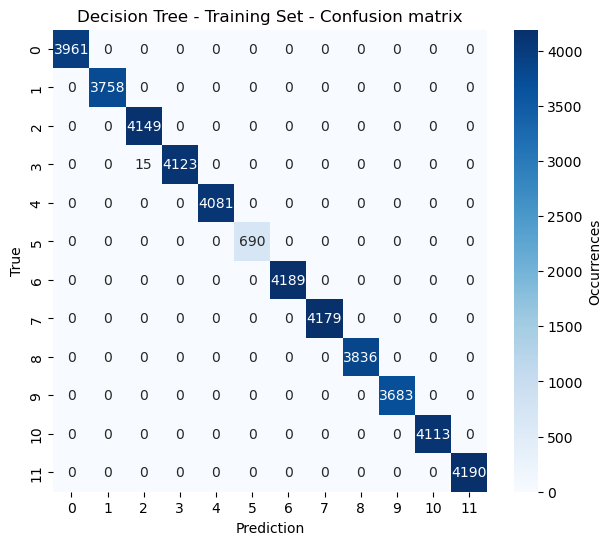

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3961
           1       1.00      1.00      1.00      3758
           2       1.00      1.00      1.00      4149
           3       1.00      1.00      1.00      4138
           4       1.00      1.00      1.00      4081
           5       1.00      1.00      1.00       690
           6       1.00      1.00      1.00      4189
           7       1.00      1.00      1.00      4179
           8       1.00      1.00      1.00      3836
           9       1.00      1.00      1.00      3683
          10       1.00      1.00      1.00      4113
          11       1.00      1.00      1.00      4190

    accuracy                           1.00     44967
   macro avg       1.00      1.00      1.00     44967
weighted avg       1.00      1.00      1.00     44967



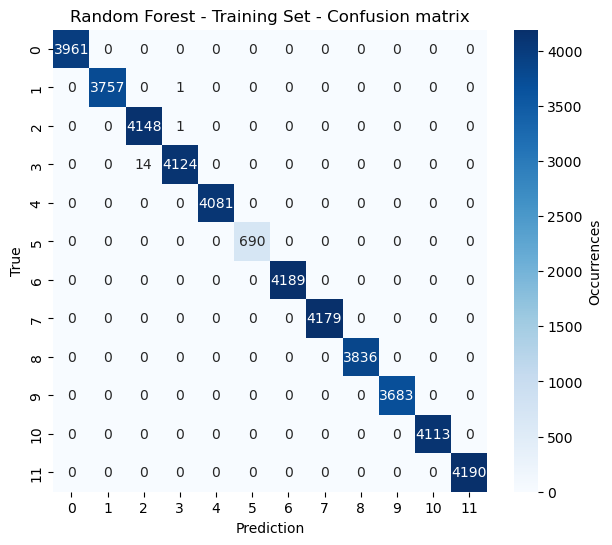

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3961
           1       1.00      1.00      1.00      3758
           2       1.00      1.00      1.00      4149
           3       1.00      1.00      1.00      4138
           4       1.00      1.00      1.00      4081
           5       1.00      1.00      1.00       690
           6       1.00      1.00      1.00      4189
           7       1.00      1.00      1.00      4179
           8       1.00      1.00      1.00      3836
           9       1.00      1.00      1.00      3683
          10       1.00      1.00      1.00      4113
          11       1.00      1.00      1.00      4190

    accuracy                           1.00     44967
   macro avg       1.00      1.00      1.00     44967
weighted avg       1.00      1.00      1.00     44967



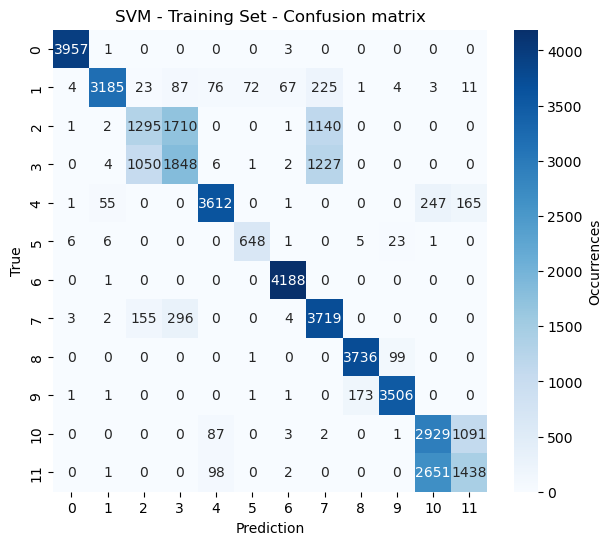

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3961
           1       0.98      0.85      0.91      3758
           2       0.51      0.31      0.39      4149
           3       0.47      0.45      0.46      4138
           4       0.93      0.89      0.91      4081
           5       0.90      0.94      0.92       690
           6       0.98      1.00      0.99      4189
           7       0.59      0.89      0.71      4179
           8       0.95      0.97      0.96      3836
           9       0.97      0.95      0.96      3683
          10       0.50      0.71      0.59      4113
          11       0.53      0.34      0.42      4190

    accuracy                           0.76     44967
   macro avg       0.78      0.78      0.77     44967
weighted avg       0.76      0.76      0.75     44967



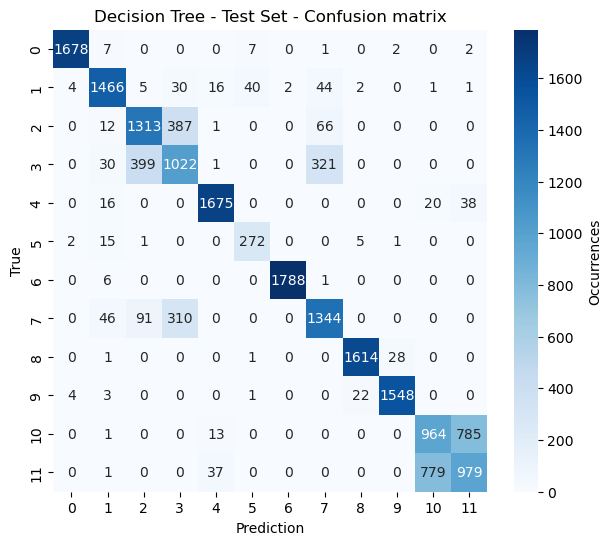

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1697
           1       0.91      0.91      0.91      1611
           2       0.73      0.74      0.73      1779
           3       0.58      0.58      0.58      1773
           4       0.96      0.96      0.96      1749
           5       0.85      0.92      0.88       296
           6       1.00      1.00      1.00      1795
           7       0.76      0.75      0.75      1791
           8       0.98      0.98      0.98      1644
           9       0.98      0.98      0.98      1578
          10       0.55      0.55      0.55      1763
          11       0.54      0.55      0.54      1796

    accuracy                           0.81     19272
   macro avg       0.82      0.82      0.82     19272
weighted avg       0.81      0.81      0.81     19272



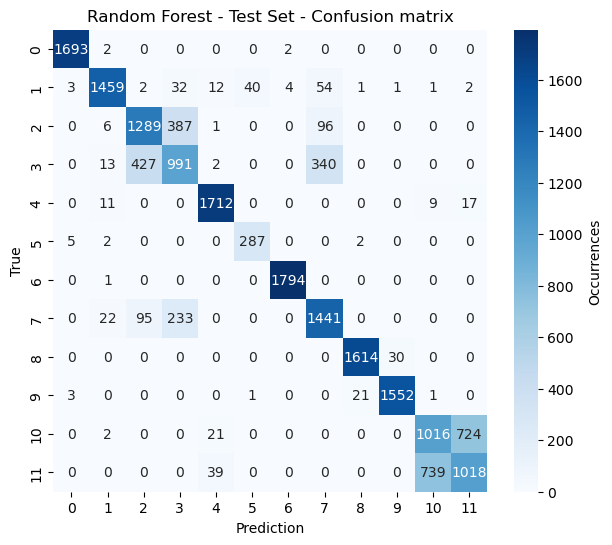

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1697
           1       0.96      0.91      0.93      1611
           2       0.71      0.72      0.72      1779
           3       0.60      0.56      0.58      1773
           4       0.96      0.98      0.97      1749
           5       0.88      0.97      0.92       296
           6       1.00      1.00      1.00      1795
           7       0.75      0.80      0.77      1791
           8       0.99      0.98      0.98      1644
           9       0.98      0.98      0.98      1578
          10       0.58      0.58      0.58      1763
          11       0.58      0.57      0.57      1796

    accuracy                           0.82     19272
   macro avg       0.83      0.84      0.83     19272
weighted avg       0.82      0.82      0.82     19272



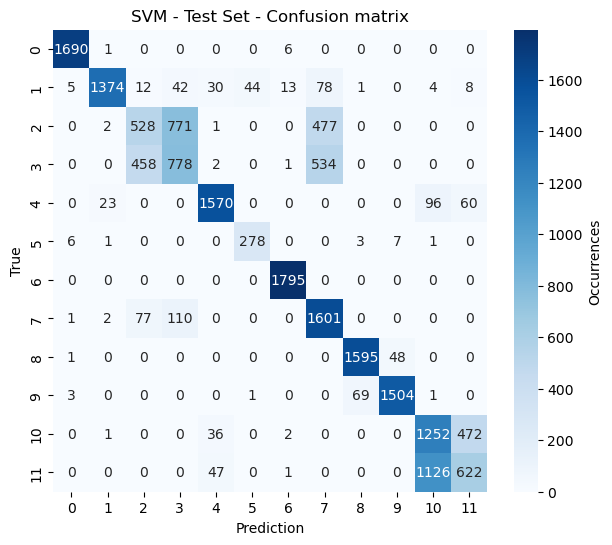

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1697
           1       0.98      0.85      0.91      1611
           2       0.49      0.30      0.37      1779
           3       0.46      0.44      0.45      1773
           4       0.93      0.90      0.91      1749
           5       0.86      0.94      0.90       296
           6       0.99      1.00      0.99      1795
           7       0.60      0.89      0.71      1791
           8       0.96      0.97      0.96      1644
           9       0.96      0.95      0.96      1578
          10       0.50      0.71      0.59      1763
          11       0.54      0.35      0.42      1796

    accuracy                           0.76     19272
   macro avg       0.77      0.77      0.76     19272
weighted avg       0.76      0.76      0.75     19272



In [5]:
def plot_confusion_matrix_and_report(y_true, y_pred, model_name, dataset_type):
    plt.figure(figsize=(7, 6))
    sns.heatmap(confusion_matrix(y_true, y_pred), cmap='Blues', annot=True, cbar_kws={'label': 'Occurrences'}, fmt='d')
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.title(f'{model_name} - {dataset_type} - Confusion matrix')
    plt.show()
    print(classification_report(y_true, y_pred))


plot_confusion_matrix_and_report(y_train, y_train_pred_dt, 'Decision Tree', 'Training Set')
plot_confusion_matrix_and_report(y_train, y_train_pred_rf, 'Random Forest', 'Training Set')
plot_confusion_matrix_and_report(y_train, y_train_pred_svm, 'SVM', 'Training Set')
plot_confusion_matrix_and_report(y_test, y_test_pred_dt, 'Decision Tree', 'Test Set')
plot_confusion_matrix_and_report(y_test, y_test_pred_rf, 'Random Forest', 'Test Set')
plot_confusion_matrix_and_report(y_test, y_test_pred_svm, 'SVM', 'Test Set')

There is overfitting in the training set.

# 3. Tune the hyper-parameters of the models through cross-validation. How do performance vary? Which model generates the best performance?

## Data preparation

In [6]:
x_train_htuning, x_val_htuning, y_train_htuning, y_val_htuning = train_test_split(x, y, stratify=y, train_size=5 / 7,
                                                                                  random_state=42)

# Standardize data and PCA
scaler_h = StandardScaler()
x_train_htuning_s = scaler_h.fit_transform(x_train_htuning)
pca = PCA(n_components=0.95)  # Adjust n_components as needed
x_train_htuning_s = pca.fit_transform(x_train_htuning_s)
x_val_htuning_s = pca.transform(scaler_h.transform(x_val_htuning))

y_train_htuning, y_val_htuning = np.ravel(y_train_htuning), np.ravel(y_val_htuning)

In [7]:
def randomized_search(model, param_dist, n_iter=50):  # Reduced n_iter
    print("Randomized Search for model:", model.__class__.__name__)
    randomized_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=n_iter, cv=2,
                                           # Reduced CV splits
                                           n_jobs=4, verbose=2, random_state=42,
                                           pre_dispatch='2*n_jobs')  # Adjusted n_jobs
    randomized_search.fit(x_train_htuning_s, y_train_htuning)
    best_model = randomized_search.best_estimator_
    accuracy = best_model.score(x_val_htuning_s, y_val_htuning)
    best_params = randomized_search.best_params_  # Get the best found parameters
    return best_model, accuracy, best_params

In [8]:
# Pre-compiled model objects
dt_clf = DecisionTreeClassifier(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

# Efficient Cross-Validation Strategy
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [9]:
# Decision Tree hyperparameters
dt_params = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Random Forest hyperparameters
rf_params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

svm_params = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
    'kernel': ['linear', 'rbf'],  # Simplified to two commonly used kernels
    # 'degree' parameter is removed to simplify, assuming 'poly' kernel is not used or less priority
}

In [10]:
svm_model, svm_accuracy, svm_best_params = randomized_search(svm_clf, svm_params)

Randomized Search for model: SVC
Fitting 2 folds for each of 12 candidates, totalling 24 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


In [11]:
dt_model, dt_accuracy, dt_best_params = randomized_search(dt_clf, dt_params)

Randomized Search for model: DecisionTreeClassifier
Fitting 2 folds for each of 50 candidates, totalling 100 fits


In [12]:
rf_model, rf_accuracy, rf_best_params = randomized_search(rf_clf, rf_params)

Randomized Search for model: RandomForestClassifier
Fitting 2 folds for each of 50 candidates, totalling 100 fits


In [13]:
# Print the best models. their accuracies and Hyperparameters
print(f"Decision Tree accuracy: {dt_accuracy}")
print(f"Random Forest accuracy: {rf_accuracy}")
print(f"SVM accuracy: {svm_accuracy}")

print("Random Forest Best Parameters:", rf_best_params)
print("Decision Tree Best Parameters:", dt_best_params)
print("SVM Best Parameters:", svm_best_params)


# Determine the best overall model
best_accuracy = max(dt_accuracy, rf_accuracy, svm_accuracy)

if best_accuracy == dt_accuracy:
    best_model = dt_clf
    best_params = dt_best_params
elif best_accuracy == rf_accuracy:
    best_model = rf_clf
    best_params = rf_best_params
else:
    best_model = svm_clf
    best_params = svm_best_params

print(f"Best model: {best_model.__class__.__name__} with accuracy {best_accuracy} and Hyperparameters {best_params}")

Decision Tree accuracy: 0.810395554102648
Random Forest accuracy: 0.8331153971886237
SVM accuracy: 0.7688787185354691
Random Forest Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 30}
Decision Tree Best Parameters: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 30, 'criterion': 'entropy'}
SVM Best Parameters: {'kernel': 'rbf', 'gamma': 'auto', 'C': 10}
Best model: RandomForestClassifier with accuracy 0.8331153971886237 and Hyperparameters {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 30}


# 4. Investigate the False Positive and False Negative. Can you draw considerations about the misclassification in terms of features? Report your analysis and findings for the ones you consider the most notable samples. 

Ciò che bisogna fare qua è: dati i modelli precedenti, allora aggiungere una colonna al df con la predicted label e poi creare due subset. Poi fare opportune considerazioni.

In [33]:
best_model.set_params(**best_params)
best_model.fit(x_train_s, y_train)
predicted_classes = best_model.predict(x_train_s)
df_withPred = x_train.copy()
# Adding the predicted classes to the DataFrame
df_withPred['Predicted Class'] = predicted_classes # There is a difference in the nr of the lines.
df_withPred['Real Class'] = y_train

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [35]:
df_withPred['misclassified'] = df_withPred['Predicted Class'] != df_withPred['Real Class']

In [36]:
df_withPred

,Source Port,Destination Port,Total Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Flow Bytes/s,Fwd IAT Min,Bwd IAT Total,...,act_data_pkt_fwd,min_seg_size_forward,Active Max,Active Min,Idle Std,Idle Min,Inbound,Predicted Class,Real Class,misclassified
61201,39512,22115,4,389.0,34.063666,0.0,0.0,1.345308e+04,0.0,0.0,...,3,-1,0.0,0.0,0.000000e+00,0.0,1,11,11,False
286,634,51810,200,440.0,0.000000,0.0,0.0,2.245528e+06,1.0,0.0,...,199,-1062718975,0.0,0.0,0.000000e+00,0.0,1,1,1,False
57983,46875,1851,2,0.0,0.000000,0.0,0.0,0.000000e+00,1.0,0.0,...,0,20,0.0,0.0,0.000000e+00,0.0,1,9,9,False
35578,926,150,2,229.0,0.000000,0.0,0.0,4.580000e+08,1.0,0.0,...,1,0,0.0,0.0,0.000000e+00,0.0,1,6,6,False
50238,62240,57299,2,0.0,0.000000,0.0,0.0,0.000000e+00,1.0,0.0,...,0,20,0.0,0.0,0.000000e+00,0.0,1,8,8,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28943,50655,443,13,46.0,22.041627,46.0,0.0,4.646600e+00,1.0,58380391.0,...,7,20,93425.0,93415.0,3.125916e+06,53866205.0,0,0,0,False
56038,45463,45107,2,0.0,0.000000,0.0,0.0,0.000000e+00,1.0,0.0,...,0,20,0.0,0.0,0.000000e+00,0.0,1,9,9,False
55364,44981,2859,2,0.0,0.000000,0.0,0.0,0.000000e+00,49.0,0.0,...,0,20,0.0,0.0,0.000000e+00,0.0,1,9,9,False
21128,61850,31891,2,590.0,0.000000,0.0,0.0,1.180000e+09,1.0,0.0,...,1,-1062718975,0.0,0.0,0.000000e+00,0.0,1,4,4,False


In [38]:
value_counts = df_withPred['misclassified'].value_counts()
value_counts

False    42795
True      2172
Name: misclassified, dtype: int64

In [42]:
# Setting up the plotting environment
sns.set(style="whitegrid")

# Visualizing the distribution of Flow Duration for different types of traffic
plt.figure(figsize=(12, 6))
sns.histplot(data=df_withPred, x="Flow Duration", hue=" label", multiple="stack", palette="Set2", binwidth=10000)
plt.title('Distribution of Flow Duration for Different Traffic Types')
plt.xlabel('Flow Duration')
plt.ylabel('Count')
plt.xlim(0, df_withPred["Flow Duration"].quantile(0.95))  # Limiting x-axis to 95th percentile for better visualization
plt.legend(title='Traffic Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Since we're visualizing a large dataset, creating a scatter plot with all points might be impractical.
# Instead, let's sample a subset of the data for clarity and quicker rendering.
sampled_df = df.sample(n=1000, random_state=1)

plt.figure(figsize=(12, 6))
sns.scatterplot(datadf_withPred, x=" Total Fwd Packets", y=" Total Backward Packets", hue=" label", palette="Set1")
plt.title('Total Forward vs. Backward Packets for Different Traffic Types')
plt.xlabel('Total Forward Packets')
plt.ylabel('Total Backward Packets')
plt.legend(title='Traffic Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

ValueError: Could not interpret value `Flow Duration` for parameter `x`

<Figure size 1200x600 with 0 Axes>